In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

# 2. EDA & 전처리

### education

In [5]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [6]:
df = pd.concat([train, test])

df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [35]:
num = 7
train['age_group'] = pd.qcut(train.age, num)
test['age_group'] = pd.qcut(test.age, num)

In [36]:
num = 7
train['fnlwgt_group'] = pd.qcut(train.fnlwgt, num)
test['fnlwgt_group'] = pd.qcut(test.fnlwgt, num)

# 3. 모델 학습

In [37]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=['Priority','Priority2']
          , numeric_features = ['education_num']
          #, ignore_features = ['fnlwgt']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 16)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,9
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 5.87 s


In [38]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.8659,0.9203,0.6555,0.7579,0.7027,0.6168,0.6197,2.7174
1,Light Gradient Boosting Machine,0.8655,0.9207,0.6500,0.7598,0.7004,0.6144,0.6177,0.3795
2,CatBoost Classifier,0.8648,0.9233,0.6322,0.7684,0.6934,0.6077,0.6127,13.4653
3,Gradient Boosting Classifier,0.8618,0.9180,0.6041,0.7755,0.6789,0.5926,0.6003,2.5255
4,Ada Boost Classifier,0.8565,0.9109,0.6196,0.7457,0.6766,0.5854,0.5897,0.9398
5,Linear Discriminant Analysis,0.8507,0.9035,0.6060,0.7322,0.6627,0.5680,0.5725,0.2214
6,Random Forest Classifier,0.8424,0.8779,0.5584,0.7275,0.6314,0.5334,0.5412,0.1250
7,Extra Trees Classifier,0.8353,0.8803,0.5830,0.6890,0.6313,0.5263,0.5295,0.6952


In [49]:
blended = blend_models(estimator_list = best_3, fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8692,0.9248,0.6375,0.7817,0.7023,0.6196,0.6249
1,0.8653,0.9199,0.6731,0.7455,0.7075,0.6203,0.6217
2,0.8653,0.9195,0.6699,0.7473,0.7065,0.6194,0.6210
3,0.8629,0.9158,0.6266,0.7628,0.6881,0.6012,0.6060
4,0.8542,0.9128,0.6149,0.7393,0.6714,0.5787,0.5828
5,0.8683,0.9334,0.6375,0.7787,0.7011,0.6177,0.6228
6,0.8809,0.9373,0.6505,0.8204,0.7256,0.6508,0.6580
7,0.8660,0.9236,0.6343,0.7717,0.6963,0.6113,0.6162
8,0.8699,0.9273,0.6440,0.7804,0.7057,0.6232,0.6279
9,0.8715,0.9234,0.6764,0.7656,0.7182,0.6354,0.6374


In [50]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8752,0.9285,0.6662,0.7854,0.7209,0.6412,0.6448


In [51]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 34s


In [52]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [53]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [54]:
submission.to_csv('output/20201022-2.csv')

In [45]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8692,0.9226,0.6505,0.7731,0.7065,0.6232,0.6270
1,0.8606,0.9155,0.6634,0.7348,0.6973,0.6070,0.6084
2,0.8653,0.9172,0.6861,0.7387,0.7114,0.6237,0.6244
3,0.8629,0.9156,0.6364,0.7568,0.6914,0.6040,0.6078
4,0.8480,0.9062,0.6117,0.7186,0.6608,0.5637,0.5667
5,0.8660,0.9279,0.6472,0.7634,0.7005,0.6150,0.6184
6,0.8723,0.9331,0.6537,0.7829,0.7125,0.6313,0.6355
7,0.8683,0.9206,0.6472,0.7722,0.7042,0.6204,0.6244
8,0.8699,0.9218,0.6537,0.7739,0.7088,0.6258,0.6295
9,0.8762,0.9221,0.7055,0.7649,0.7340,0.6535,0.6544


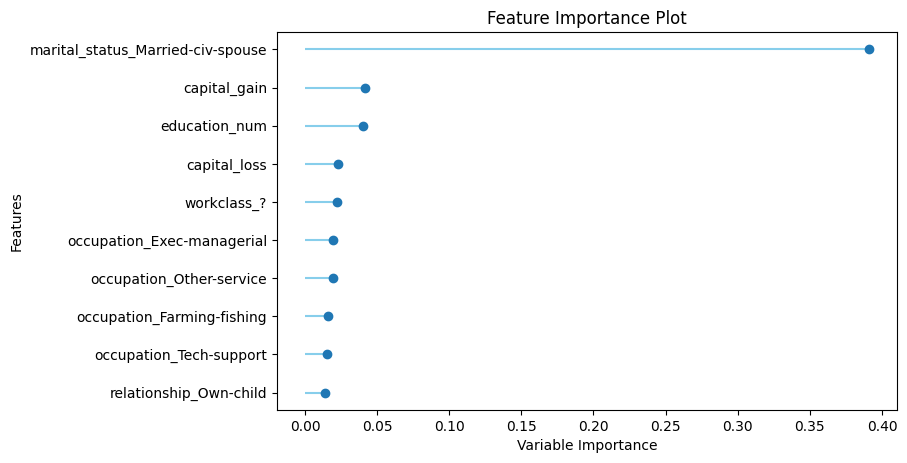

In [46]:
plot_model(estimator = xgboost, plot = 'feature')

In [47]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8614,0.9217,0.6278,0.7578,0.6867,0.5987,0.6031
1,0.8630,0.9189,0.6731,0.7376,0.7039,0.6150,0.6161
2,0.8637,0.9154,0.6699,0.7419,0.7041,0.6159,0.6172
3,0.8558,0.9110,0.6234,0.7385,0.6761,0.5842,0.5876
4,0.8542,0.9115,0.6181,0.7375,0.6725,0.5797,0.5835
5,0.8738,0.9314,0.6634,0.7824,0.7180,0.6375,0.6411
6,0.8817,0.9330,0.6699,0.8086,0.7327,0.6576,0.6624
7,0.8613,0.9189,0.6375,0.7519,0.6900,0.6014,0.6048
8,0.8683,0.9253,0.6375,0.7787,0.7011,0.6177,0.6228
9,0.8715,0.9201,0.6796,0.7636,0.7192,0.6362,0.6380


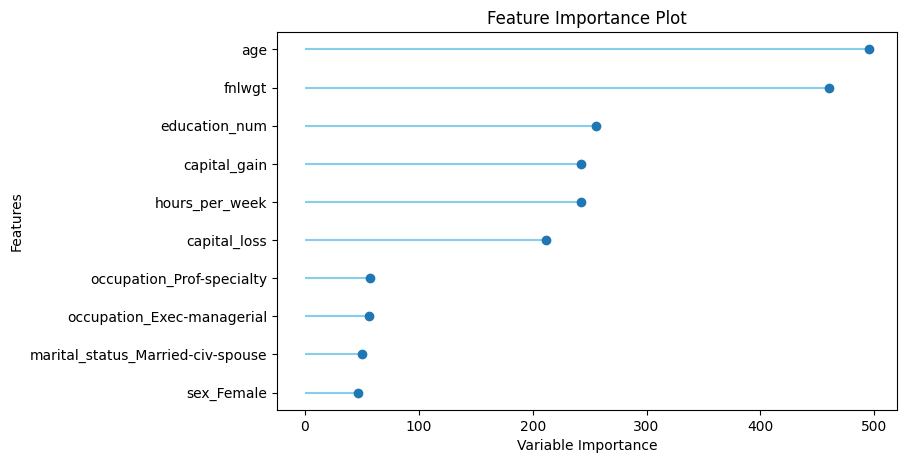

In [48]:
plot_model(estimator = lightgbm, plot = 'feature')